In [1]:
%matplotlib inline

In [2]:
###############################################################################
"""
Python Glacier Evolution Model "PyGEM" V1.0
Prepared by David Rounce with support from Regine Hock.
This work was funded under the NASA HiMAT project (INSERT PROJECT #).

PyGEM is an open source glacier evolution model written in python.  Model
details come from Radic et al. (2013), Bliss et al. (2014), and Huss and Hock
(2015).
"""
###############################################################################
# This is the main script that provides the architecture and framework for all
# of the model runs. All input data is included in a separate module called
# pygem_input.py. It is recommended to not make any changes to this file unless
# you are a PyGEM developer and making changes to the model architecture.
#
#========== IMPORT PACKAGES ==================================================
# Various packages are used to provide the proper architecture and framework
# for the calculations used in this script. Some packages (e.g., datetime) are
# included in order to speed of calculations and simplify code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os # os is used with re to find name matches
import re # see os
# import xarray as xr
import netCDF4 as nc
from time import strftime
#========= IMPORT MODEL INPUTS ===============================================
from pygem_input import *
    # import all data
    # pygem_input.py contains all the input data
#========== IMPORT FUNCTIONS FROM MODULES ====================================
import pygemfxns_modelsetup as modelsetup
import pygemfxns_climate as climate
import pygemfxns_massbalance as massbalance

In [3]:
#========== OTHER STEPS ======================================================
# Other steps:
# Geodetic mass balance file path
# ???[Create input script full of option list]???
#       - Select regions: (Option 1 - default regions from RGI inventory)
#                         (Option 2 - custom regions)
#       - Select climate data:
#           - climate data source/file name
#           - climate data resolution
#           - sampling scheme (nearest neighbor, etc.)
#       - Model run type: (Option 1 - calibration)
#                         (Option 2 - simulation)
#

#========== LIST OF OUTPUT ===================================================
# Create a list of outputs (.csv or .txt files) that the user can choose from
# depending on what they are using the model for or want to see:
#    1. Time series of all variables for each grid point (x,y,z) of each glacier
#       and every time step
#       (--> comparing with point balances)
#    2. Time series of all variables for elevation bands if spatial
#       discretization is elevation bands (x,y,z) of each glacier and every time
#       step
#       (--> comparing with profiles)
#    3. as above but all variables averaged over current single glacier surfaces
#       (--> comparing with geodetic mass balances of glaciers)
#    4. Time series of all variables averaged over region
#       (--> comparison to GRACE)
#    5. Time series of seasonal balance for individual glaciers
#       (--> comparison to WGMS data)
# Also develop output log file, i.e., file that states input parameters,
# date of model run, model options selected, and any errors that may have come
# up (e.g., precipitation corrected because negative value, etc.)

#========== MODEL RUN DETAILS ================================================
# The model is run through a series of steps:
#   > Step 01: Region/Glaciers Selection
#              The user needs to define the region/glaciers that will be used in
#              the model run.  The user has the option of choosing the standard
#              RGI regions or defining their own.
#   > Step 02: Model Time Frame
#              The user should consider the time step and duration of the model
#              run along with any calibration product and/or model spinup that
#              may be included as well.
#   > Step 03: Climate Data
#              The user has the option to choose the type of climate data being
#              used in the model run, and how that data will be downscaled to
#              the glacier and bins.
#   > Step 04: Glacier Evolution
#              The heart of the model is the glacier evolution, which includes
#              calculating the specific mass balance, the surface type, and any
#              changes to the size of the glacier (glacier dynamics). The user
#              has many options for how this aspect of the model is run.
#   > Others: model output? model input?

In [4]:
#----- STEP ONE: MODEL REGION/GLACIERS ---------------------------------------
# Step one involves the selection of the regions and glaciers used in the model.
# Regions/glacier included in the model run will be defined using the Randolph
#   Glacier inventory.  For more information, see:
#     https://www.glims.org/RGI/ (RGI Consortium, 2017)
# In step one, the model will:
#   > select glaciers included in model run

# Select glaciers that are included in the model run
# Glacier Selection Options:
#   > 1 (default) - enter numbers associated with RGI V6.0 and select
#                   glaciers accordingly
#   > 2 - glaciers/regions selected via shapefile
#   > 3 - glaciers/regions selected via new table (other inventory)
#
if option_glacier_selection == 1:
    main_glac_rgi = modelsetup.selectglaciersrgitable()
elif option_glacier_selection == 2:
    # OPTION 2: CUSTOMIZE REGIONS USING A SHAPEFILE that specifies the
    #           various regions according to the RGI IDs, i.e., add an
    #           additional column to the RGI table.
    # ??? [INSERT CODE FOR IMPORTING A SHAPEFILE] ???
    #   (1) import shapefile with custom boundaries, (2) grab the RGIIDs
    #   of glaciers that are in these boundaries, (3) perform calibration
    #   using these alternative boundaries that may (or may not) be more
    #   representative of regional processes/climate
    #   Note: this is really only important for calibration purposes and
    #         post-processing when you want to show results over specific
    #         regions.
    # Development Note: if create another method for selecting glaciers,
    #                   make sure that update way to select glacier
    #                   hypsometry as well.
    print('\n\tMODEL ERROR (selectglaciersrgi): this option to use'
          '\n\tshapefiles to select glaciers has not been coded yet.'
          '\n\tPlease choose an option that exists. Exiting model run.\n')
    exit()
else:
    # Should add options to make regions consistent with Brun et al. (2017),
    # which used ASTER DEMs to get mass balance of 92% of the HMA glaciers.
    print('\n\tModel Error (selectglaciersrgi): please choose an option'
          '\n\tthat exists for selecting glaciers. Exiting model run.\n')
    exit()


This study is only focusing on glaciers ['03473', '03733'] in region [15].
The 'select_rgi_glaciers' function has finished.


In [5]:
#----- STEP TWO: ADDITIONAL MODEL SETUP --------------------------------------
# Step two runs more functions related to the model setup. This section has been
#   separated from the selection of the model region/glaciers in order to
#   keep the input organized and easy to read.
# In step two, the model will:
#   > select glacier hypsometry
#   > define the model time frame
#   > define the initial surface type

# Glacier hypsometry
# main_glac_hyps = modelsetup.hypsometryglaciers(main_glac_rgi)
    # Note: need to adjust this hypsometry into separate functions such that it
    #       is easier to follow.
# AUTOMATE THIS TO LOAD THEM IN INSTEAD OF CHOOSING THEM
# main_glac_hyps = pd.read_csv(hyps_filepath + 'RGI_13_area_test20170905.csv')
ds = pd.read_csv(hyps_filepath + 'bands_10m_DRR/area_15_Huss_SouthAsiaEast_10m.csv')
# print(ds.head())
# Select glaciers based on 01Index value from main_glac_rgi table
glac_hyps_table = pd.DataFrame()
for glacier in range(len(main_glac_rgi)):
    if glac_hyps_table.empty:
        glac_hyps_table = ds.loc[main_glac_rgi.loc[glacier,'O1Index']]
    else:
        glac_hyps_table = pd.concat([glac_hyps_table, ds.loc[main_glac_rgi.loc[glacier,'O1Index']]], axis=1)
glac_hyps_table = glac_hyps_table.transpose()
# print(glac_hyps_table.head())
# Clean up table and re-index
# Reset index to be GlacNo
glac_hyps_table.reset_index(drop=True, inplace=True)
glac_hyps_table.index.name = indexname
# Drop columns that are not elevation bins
glac_hyps_table.drop(['RGI-ID','Cont_range'], axis=1, inplace=True)
# Make sure columns are integers
glac_hyps_table.columns = glac_hyps_table.columns.values.astype(int)
# Change NAN from -99 to 0
glac_hyps_table[glac_hyps_table==-99] = 0.
# Add empty rows such that bins are consistent for every region
bins = np.arange(int(binsize/2),9000,binsize)
# print(glac_hyps_table.shape[1])
# Find when bins agree and enter
main_glac_hyps = pd.DataFrame(0, index=glac_hyps_table.index, columns=bins)
# print(main_glac_hyps.shape)
for cols in range(main_glac_hyps.shape[1]):
    column_value = main_glac_hyps.columns.values[cols]
    if column_value in glac_hyps_table.columns:
        main_glac_hyps.loc[:, column_value] = glac_hyps_table.loc[:, column_value]
print(main_glac_hyps.loc[:,5005:5065])

          5005    5015     5025    5035     5045     5055     5065
GlacNo                                                            
0         0.55  0.4875    0.375  0.3925   0.2925   0.2975    0.355
1       0.1275   0.105  0.12062  0.0875  0.11688  0.08625  0.09813


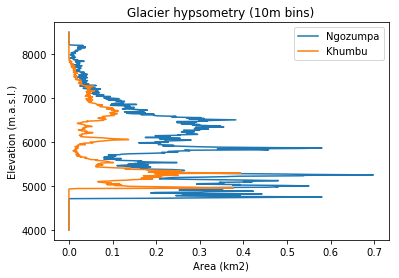

In [6]:
# Plot glacier hypsometry using matplotlib
plt.figure(1)
plt.plot(main_glac_hyps.iloc[0,400:850], main_glac_hyps.columns.values[400:850])
plt.plot(main_glac_hyps.iloc[1,400:850], main_glac_hyps.columns.values[400:850])
plt.legend(('Ngozumpa', 'Khumbu'))
plt.xlabel('Area (km2)')
plt.ylabel('Elevation (m.a.s.l.)')
plt.title('Glacier hypsometry (10m bins)')

In [7]:
# Glacier initial ice thickness
# AUTOMATE THIS WITH A FUNCTION (same function as hypsometry with different input)
# main_glac_icethickness = pd.read_csv(hyps_filepath +
#                                      'RGI_13_thickness_test20170905.csv')
ds2 = pd.read_csv(hyps_filepath + 'bands_10m_DRR/thickness_15_Huss_SouthAsiaEast_10m.csv')
# print(ds2.head())
# Select glaciers based on 01Index value from main_glac_rgi table
glac_thickness_table = pd.DataFrame()
for glacier in range(len(main_glac_rgi)):
    if glac_thickness_table.empty:
        glac_thickness_table = ds2.loc[main_glac_rgi.loc[glacier,'O1Index']]
    else:
        glac_thickness_table = pd.concat([glac_thickness_table, ds2.loc[main_glac_rgi.loc[glacier,'O1Index']]], axis=1)
glac_thickness_table = glac_thickness_table.transpose()
# print(glac_thickness_table.head())
# Clean up table and re-index
# Reset index to be GlacNo
glac_thickness_table.reset_index(drop=True, inplace=True)
glac_thickness_table.index.name = indexname
# Drop columns that are not elevation bins
glac_thickness_table.drop(['RGI-ID','Cont_range'], axis=1, inplace=True)
# Make sure columns are integers
glac_thickness_table.columns = glac_thickness_table.columns.values.astype(int)
# Change NAN from -99 to 0
glac_thickness_table[glac_thickness_table==-99] = 0
# Add empty rows such that bins are consistent for every region
# bins = np.arange(int(binsize/2),9000,binsize)
# print(glac_thickness_table.shape[1])
# Find when bins agree and enter
main_glac_icethickness = pd.DataFrame(0, index=glac_thickness_table.index, columns=bins)
# print(main_glac_thickness.shape)
for cols in range(main_glac_icethickness.shape[1]):
    column_value = main_glac_icethickness.columns.values[cols]
    if column_value in glac_thickness_table.columns:
        main_glac_icethickness.loc[:, column_value] = glac_thickness_table.loc[:, column_value]
print(main_glac_icethickness.loc[:,5005:5065])
# print(glac_thickness_table.head())

         5005   5015   5025   5035   5045   5055   5065
GlacNo                                                 
0       185.5  178.5  172.9  175.7  179.4  179.7  188.7
1       104.8  112.4  109.9  106.9  103.2  102.4   97.5


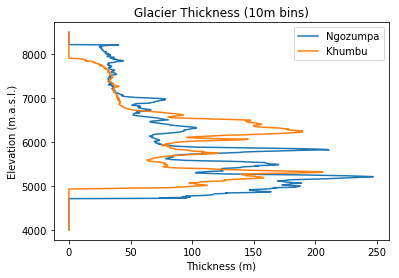

In [8]:
# Plot glacier ice thickness
plt.figure(1)
plt.plot(main_glac_icethickness.iloc[0,400:850], main_glac_hyps.columns.values[400:850])
plt.plot(main_glac_icethickness.iloc[1,400:850], main_glac_hyps.columns.values[400:850])
plt.legend(('Ngozumpa', 'Khumbu'))
plt.xlabel('Thickness (m)')
plt.ylabel('Elevation (m.a.s.l.)')
plt.title('Glacier Thickness (10m bins)')

In [9]:
# ADD OPTION FOR VOLUME-AREA SCALING

# Glacier total initial volume
main_glac_rgi['Volume'] = (
    (main_glac_hyps * main_glac_icethickness/1000).sum(axis=1))
    # volume [km3] = area[km2] * thickness[m] * (1 [km] / 1000 [m])

print(main_glac_rgi.head(),'\n')

        O1Index           RGIId     CenLon     CenLat  O1Region  O2Region  \
GlacNo                                                                      
0          3472  RGI60-15.03473  86.715912  28.089468        15         2   
1          3732  RGI60-15.03733  86.903244  27.974716        15         2   

          Area  Zmin  Zmax  Zmed  Slope  Aspect   Lmax    Volume  
GlacNo                                                            
0       61.054  4702  8181  5815   16.5     180  18285  7.057732  
1       19.097  4926  7870  5568   17.5     262  15396  1.976989   



In [10]:
# Model time frame
#   Set up table of dates. These dates are used as column headers for many other
#   variables in the model run, so it's important to be an initial step.
dates_table, start_date, end_date = modelsetup.datesmodelrun(option_wateryear, option_leapyear)
# print(dates_table.head())
print(dates_table.head(15))
# print(start_date)

The 'datesmodelrun' function has finished.
               date  year  month  daysinmonth  wateryear
timestep                                                
0        2000-10-01  2000     10           31       2001
1        2000-11-01  2000     11           30       2001
2        2000-12-01  2000     12           31       2001
3        2001-01-01  2001      1           31       2001
4        2001-02-01  2001      2           28       2001
5        2001-03-01  2001      3           31       2001
6        2001-04-01  2001      4           30       2001
7        2001-05-01  2001      5           31       2001
8        2001-06-01  2001      6           30       2001
9        2001-07-01  2001      7           31       2001
10       2001-08-01  2001      8           31       2001
11       2001-09-01  2001      9           30       2001
12       2001-10-01  2001     10           31       2002
13       2001-11-01  2001     11           30       2002
14       2001-12-01  2001     12           31

In [11]:
# Initial surface type defined according to being above or below the median elevation
main_glac_surftypeinit = modelsetup.surfacetypeglacinitial(option_surfacetype_initial,
                                                           option_surfacetype_firn,
                                                           option_surfacetype_debris,
                                                           main_glac_rgi,
                                                           main_glac_hyps)
print(main_glac_surftypeinit.head())

The 'initialsurfacetype' function has finished.
        5     15    25    35    45    55    65    75    85    95    ...   \
GlacNo                                                              ...    
0          0     0     0     0     0     0     0     0     0     0  ...    
1          0     0     0     0     0     0     0     0     0     0  ...    

        8905  8915  8925  8935  8945  8955  8965  8975  8985  8995  
GlacNo                                                              
0          0     0     0     0     0     0     0     0     0     0  
1          0     0     0     0     0     0     0     0     0     0  

[2 rows x 900 columns]


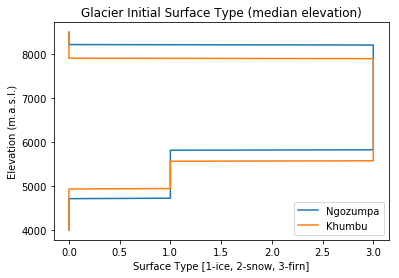

In [12]:
# Plot initial surface type
plt.figure(1)
plt.plot(main_glac_surftypeinit.iloc[0,400:850], main_glac_hyps.columns.values[400:850])
plt.plot(main_glac_surftypeinit.iloc[1,400:850], main_glac_hyps.columns.values[400:850])
plt.legend(('Ngozumpa', 'Khumbu'))
plt.xlabel('Surface Type [1-ice, 2-snow, 3-firn]')
plt.ylabel('Elevation (m.a.s.l.)')
plt.title('Glacier Initial Surface Type (median elevation)')

In [13]:
# Mass balance estimates from High-res DEMs
mb_filepath = '../DEMs/hma_mb_20170717_1846.csv'
# mb_filepath = os.path.dirname(__file__) + '/../DEMs/hma_mb_20170717_1846.csv'
main_glac_mb_raw = pd.read_csv(mb_filepath)
# print(main_glac_mb_raw.head())
print(main_glac_mb_raw.loc[main_glac_mb_raw['# glacnum'] == 15.03473])
# print(main_glac_mb_raw.iloc[8690:8694,:])
# Having trouble finding Khumbu Glacier (mb = -0.7 m w.e. a-1)
# print(main_glac_mb_raw.loc[main_glac_mb_raw['# glacnum'] == 15.03733])
# print(main_glac_mb_raw.shape)
print('\nNeed to extract Khumbu Glacier and automate this process')

      # glacnum          x          y    z_med    z_p16    z_p84  mb_mwea  \
6256   15.03473  166571.02 -892626.41  5695.44  4978.04  6478.77    -0.39   

      area_km2       t1      t2     dt  
6256     61.05  2000.11  2015.0  14.89  

Need to extract Khumbu Glacier and automate this process


In [14]:
#----- STEP THREE: CLIMATE DATA ----------------------------------------------
# Step three imports the climate data that will be used in the model run.
# Provide options for the selection and downscaling of the data
#    - default: nearest neighbor
#    - alternatives: weighted methods
#      (note: prior to any weighting, lapse rates/biases need to be applied)
# Important to consider the following:
#    - time period of the calibration data or model run
#    - type of model (DDF, EBM, etc.) will dictate meteorological data needed
#   Datasets:
#     Past: Default: ERA reanslysis?
#           Alternatives: COAWST (S.Nichols), NCEP/NCAR(?), others?
#                         automatic weather stations
#     Future: Default: GCMs (see glacierMIP project emails to download data)
#             Alternatives: COAWST (S.Nichols), others?

In [17]:
# In step three, the model will:
#   > import meteorological data
#   > select meteorological data for each glacier based on specified option
#       default: nearest neighbor
if option_gcm_downscale == 1:
    # OPTION 1 (default): NEAREST NEIGHBOR
    # Thoughts on 2017/08/21:
    #   > Pre-processing functions should be coded and added after the initial
    #     import such that the initial values can be printed if necessary.
    #   > Data imported here is monthly, i.e., it is 1 value per month. If the
    #     data is going to be subsampled to a daily resolution in order to
    #     estimate melt in areas with low monthly mean temperature as is done in
    #     Huss and Hock (2015), then those calculations should be performed in
    #     the ablation section.
    gcm_glac_temp, gcm_time_series = climate.importGCMvarnearestneighbor(gcm_temp_filename,
                                                                         gcm_temp_varname,
                                                                         main_glac_rgi,
                                                                         dates_table,
                                                                         start_date,
                                                                         end_date)
        # gcm nearest neighbor time series for each glacier with GlacNo index
        # rows = # of glaciers, cols = length of time series
    gcm_glac_prec, gcm_time_series = climate.importGCMvarnearestneighbor(gcm_prec_filename,
                                                                         gcm_prec_varname,
                                                                         main_glac_rgi,
                                                                         dates_table,
                                                                         start_date,
                                                                         end_date)
        # gcm nearest neighbor time series for each glacier with GlacNo index
        # rows = # of glaciers, cols = length of time series
    gcm_glac_elev = climate.importGCMfxnearestneighbor(gcm_elev_varname,
                                                       main_glac_rgi)
        # gcm nearest neighbor surface altitude for each glacier with GlacNo
        # index, rows = # of glaciers, cols = 1 (Series)
else:
    print('\n\tModel Error: please choose an option that exists for'
          '\n\tdownscaling climate data. Exiting model run now.\n')
    exit() # if you have an error, exit the model run

The 'importGCMvarnearestneighbor' fxn for 't2m' has finished.
The 'importGCMvarnearestneighbor' fxn for 'tp' has finished.
The 'importGCMfxnearestneighbor' fxn for 'z' has finished.


In [19]:
# Add column of the dates from the gcm data
dates_table['date_gcm'] = gcm_time_series
print(dates_table.head())

               date  year  month  daysinmonth  wateryear   date_gcm
timestep                                                           
0        2000-10-01  2000     10           31       2001 2000-10-01
1        2000-11-01  2000     11           30       2001 2000-11-01
2        2000-12-01  2000     12           31       2001 2000-12-01
3        2001-01-01  2001      1           31       2001 2001-01-01
4        2001-02-01  2001      2           28       2001 2001-02-01



Sample of glacier temp:
 date    2000-10-01  2000-11-01  2000-12-01  2001-01-01  2001-02-01  \
GlacNo                                                               
0         7.326497    2.181494    -0.49015   -2.083396   -1.208502   
1         7.326497    2.181494    -0.49015   -2.083396   -1.208502   

date    2001-03-01  2001-04-01  2001-05-01  2001-06-01  2001-07-01  \
GlacNo                                                               
0         0.438664    4.628762    7.954403   12.144501   13.231596   
1         0.438664    4.628762    7.954403   12.144501   13.231596   

date       ...      2014-12-01  2015-01-01  2015-02-01  2015-03-01  \
GlacNo     ...                                                       
0          ...       -0.554506   -2.881759   -1.281555    1.085703   
1          ...       -0.554506   -2.881759   -1.281555    1.085703   

date    2015-04-01  2015-05-01  2015-06-01  2015-07-01  2015-08-01  2015-09-01  
GlacNo                                            

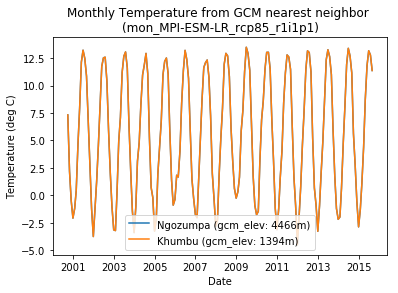

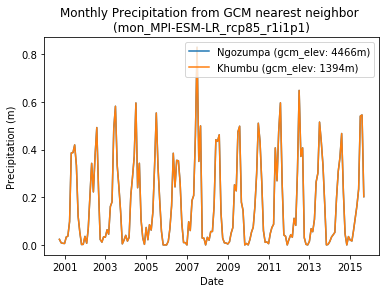

In [20]:
# Print nearest neighbor
# print('\nGCM nearest neighbor Temperature:')
# print(gcm_glac_temp.iloc[:,0:12])
# print(gcm_glac_temp.iloc[:,12:24])
# print('\nGCM nearest neighbor Precipitation:')
# print(gcm_glac_prec.iloc[:,0:12])
# print(gcm_glac_prec.iloc[:,12:24])
print('\nSample of glacier temp:\n', gcm_glac_temp.head())
print('\nSample of glacier prec:\n', gcm_glac_prec.head())
print(gcm_glac_elev)
# Plot nearest neighbor meteorological data using matplotlib
plt.figure(1)
plt.plot(gcm_glac_temp.columns.values, gcm_glac_temp.iloc[0,:])
plt.plot(gcm_glac_temp.columns.values, gcm_glac_temp.iloc[1,:])
plt.legend(('Ngozumpa (gcm_elev: 4466m)', 'Khumbu (gcm_elev: 1394m)'))
plt.xlabel('Date')
plt.ylabel('Temperature (deg C)')
plt.title('Monthly Temperature from GCM nearest neighbor \n(mon_MPI-ESM-LR_rcp85_r1i1p1)')
# Plot nearest neighbor meteorological data using matplotlib
plt.figure(2)
plt.plot(dates_table.loc[:,'date'],gcm_glac_prec.iloc[0,:])
plt.plot(dates_table.loc[:,'date'],gcm_glac_prec.iloc[1,:])
plt.xlabel('Date')
plt.ylabel('Precipitation (m)')
plt.legend(('Ngozumpa (gcm_elev: 4466m)', 'Khumbu (gcm_elev: 1394m)'))
plt.title('Monthly Precipitation from GCM nearest neighbor \n(mon_MPI-ESM-LR_rcp85_r1i1p1)')

In [22]:
gcm_prec_annual_sum = massbalance.groupbyyearsum(gcm_glac_prec)
annual_columns = np.arange(dates_table.loc[0,'wateryear'], dates_table.loc[dates_table.shape[0]-1,'wateryear'] + 1)
gcm_prec_annual_sum.columns = annual_columns
print(gcm_prec_annual_sum)
# Compared to mean annual total of precipitation from 1994-2013 at Pyramid Station (0.449 m)

            2001      2002      2003      2004      2005      2006      2007  \
GlacNo                                                                         
0       2.407265  2.580147  2.127184  2.011264  2.233871  2.376085  2.332296   
1       3.353540  3.017965  2.794219  2.657089  3.169050  2.604830  3.280841   

            2008      2009      2010      2011      2012      2013      2014  \
GlacNo                                                                         
0       2.395520  2.043245  2.228855  2.362906  2.427112  2.024214  1.501532   
1       2.495919  3.011289  3.000573  2.514915  2.886036  2.160944  1.930408   

            2015  
GlacNo            
0       2.136954  
1       3.006374  


In [23]:
# xarray not working to import climate data due to errors associated with the selection of latitude for some reason...

# use xarray to select climate data
# xarray is built to emulate the netcdf framework, is built on top of pandas,
# and is lazy - it won't load in the data until it is used.
# Therefore, instead of importing everything and then selecting the data as needed,
# xarray will only import the data that is being used.  It should greatly speed up 
# computational time.

# import xarray as xr
# variablename = 'tas'
# # Import netcdf file
# filefull = gcm_filepath_var + variablename + gcm_filename_var
# data = xr.open_mfdataset(filefull)
# # mfdataset uses dask to speed up processing
# print(data['tas'])
# data.coords
# data.sel(time='2000-01-15')
# data.sel(lon=180.0)
# data['tas'].sel(lon=180.0)
# data['tas'].sel(time='2015lon=180.0)

In [24]:
# ----- STEP FOUR: CALCULATE SPECIFIC MASS BALANCE --------------------------
# Step four computes the specific mass balance for every bin on each glacier
#   over the time span of the model run.
# In step four, the model will:
#   > set parameters or input calibrated parameters
#   > compute specific mass balance for each bin on each glacier (loop)
#
# Specify calibrated parameters:
""" THIS NEEDS TO BE SPECIFIED IN INPUT OR SEPARATE SECTION DEPENDING ON WHAT IS
    CONSIDERED TO BE THE CLEAREST/MOST ORGANIZED MANNER """
main_glac_parameters = main_glac_rgi.loc[:,['RGIId']]
main_glac_parameters['lr_gcm'] = -0.0065
# lapse rate (K m-1) for gcm to glacier
main_glac_parameters['lr_glac'] = -0.0065
# lapse rate (K m-1) on glacier for bins
main_glac_parameters['prec_factor'] = 0.2
# precipitation correction factor (-)
#   k_p in Radic et al. (2013)
#   c_prec in Huss and Hock (2015)
main_glac_parameters['prec_grad'] = 0.0001
# precipitation gradient on glacier (% m-1)
main_glac_parameters['DDF_ice'] = 7.2 * 10**-3
# DDF ice (m w.e. d-1 degC-1)
# note: '**' means to the power, so 10**-3 is 0.001
main_glac_parameters['DDF_snow'] = 4.0 * 10**-3
# DDF snow (m w.e. d-1 degC-1)
main_glac_parameters['T_snow'] = 0
# temperature threshold for snow (C)
#   Huss and Hock (2015) T_snow = 1.5 deg C with +/- 1 deg C for ratios
main_glac_parameters['DDF_firn'] = main_glac_parameters[['DDF_ice', 'DDF_snow']].mean(axis=1)
# DDF firn (m w.e. d-1 degC-1)
# DDF_firn is average of DDF_ice and DDF_snow (Huss and Hock, 2015)

In [25]:
# Compute the mass balance for each glacier (glacier by glacier)

# Create empty dataframes for glacier-wide variables (i.e., not for each bin) for each year
# Annual total glacier volume at start of each year
main_glac_volume_annual = pd.DataFrame(0,index=main_glac_rgi.index, columns=annual_columns)
main_glac_volume_annual.iloc[:,0] = main_glac_rgi['Volume']
# Annual total glacier area at start of each year
main_glac_area_annual = pd.DataFrame(0,index=main_glac_rgi.index, columns=annual_columns)
main_glac_area_annual.iloc[:,0] = main_glac_rgi['Area']
# Annual glacier-wide specific mass balance
main_glac_massbal_annual = pd.DataFrame(0,index=main_glac_rgi.index, columns=annual_columns)
# Create dataframe for annual ELA for each glacier
main_glac_ELA = pd.DataFrame(0, index=main_glac_rgi.index, columns=annual_columns)

In [26]:
# Create netcdf of each time step for each variable, which will enable output processing

netcdf_filename = 'glac_bin_monthly_output_rgi' + str(rgi_regionsO1[0]) + '_' + str(strftime("%Y%m%d")) + '.nc'
netcdf_filepath = '../Output/'
netcdf_fileformat = 'NETCDF4_CLASSIC'

# Create the netcdf file open to write ('w') with the netCDF4 classic file format
monthlybin_netcdf = nc.Dataset(netcdf_filepath + netcdf_filename, 'w', format=netcdf_fileformat)

# Create global attributes
monthlybin_netcdf.description = 'Monthly specific mass balance for each glacier in the model run'
monthlybin_netcdf.history = 'Created ' + str(strftime("%Y-%m-%d %H:%M:%S"))
monthlybin_netcdf.source = 'Python Global Glacier Evolution Model'

# Create dimensions
glacier = monthlybin_netcdf.createDimension('glacier', None)
binelev = monthlybin_netcdf.createDimension('binelev', main_glac_hyps.shape[1])
time = monthlybin_netcdf.createDimension('time', dates_table.shape[0])

# Create variables
binelev_out = monthlybin_netcdf.createVariable('binelev', np.int32, ('binelev',))
binelev_out.long_name = "center bin elevation"
binelev_out.standard_name = "bin_elevation"
binelev_out.units = "meters above sea level"
binelev_out[:] = main_glac_hyps.columns.values

time_out = monthlybin_netcdf.createVariable('time', np.float64, ('time',))
time_out.long_name = "date of model time step (monthly)"
time_out.standard_name = "date"
time_out.units = "days since 1900-01-01 00:00:00"
time_out.calendar = "gregorian"
time_out[:] = nc.date2num(dates_table['date'].astype(datetime), units = time_out.units, calendar = time_out.calendar)
# print(dates_table['date'].astype)
# time_out[:] = nc.date2num(dates_table['date_climate'].astype(datetime), units = time_out.units, calendar = time_out.calendar)

glacier_out = monthlybin_netcdf.createVariable('glacier', np.int32, ('glacier',))
glacier_out.long_name = "glacier number associated with model run"
glacier_out.standard_name = "GlacNo"
glacier_out.units = "-"

# Create the 3-d variables being recorded
temp = monthlybin_netcdf.createVariable('temp', np.float64, ('glacier', 'binelev', 'time'))
temp.long_name = "air temperature "
temp.standard_name = "temperature"
temp.units = "degC"
prec = monthlybin_netcdf.createVariable('prec', np.float64, ('glacier', 'binelev', 'time'))
prec.long_name = "precipitation"
prec.standard_name = "precipitation"
prec.units = "m"
snow = monthlybin_netcdf.createVariable('snow', np.float64, ('glacier', 'binelev', 'time'))
snow.long_name = "solid precipitation"
snow_standard_name = "snow"
snow.units = "m"
massbal = monthlybin_netcdf.createVariable('massbal', np.float64, ('glacier', 'binelev', 'time'))
massbal.long_name = "specific mass balance of each elevation bin"
massbal.standard_name = "mass balance"
massbal.units = "m w.e. per square meter"
melt_surf = monthlybin_netcdf.createVariable('melt_surf', np.float64, ('glacier', 'binelev', 'time'))
melt_surf.long_name = "specific surface melt (excludes melt of snow on top of the surface)"
melt_surf.standard_name = "surface melt"
melt_surf.units = "m w.e. per square meter"
melt_snow = monthlybin_netcdf.createVariable('melt_snow', np.float64, ('glacier', 'binelev', 'time'))
melt_snow.long_name = "specific snow melt above the surface regardless of underlying surface type"
melt_snow.standard_name = "snow melt"
melt_snow.units = "m w.e. per square meter"
refreeze = monthlybin_netcdf.createVariable('refreeze', np.float64, ('glacier', 'binelev', 'time'))
refreeze.long_name = "refreezing of melted snow"
refreeze.standard_name = "refreezing"
refreeze.units = "m"
snowonsurface = monthlybin_netcdf.createVariable('snowonsurface', np.float64, ('glacier', 'binelev', 'time'))
snowonsurface.long_name = "snow on the surface of the glacier"
snowonsurface.standard_name = "snow on the surface"
snowonsurface.units = "m"

In [ ]:
# NOTE: CAN ADD COMMENTS TO THE NETCDF VARIABLES to help clarify what the output is describing - this will be helpful for
# clarifying specific mass balance, etc.
#   massbal.comment = "enter comment here"

In [46]:
# Compute annual divisor
if timestep == 'monthly':
    annual_divisor = 12
elif timestep == 'daily':
    print('Need to write according to leapyear.  Code this. Exiting now.')
    exit()
# annual divisor is used to interact with annual dataframes and perform calculations each year

In [63]:
# for glac in range(main_glac_rgi.shape[0]):
for glac in [0]:
    # Downscale the gcm temperature to each bin
    glac_bin_temp = massbalance.downscaletemp2bins(option_temp2bins,
                                                   option_elev_ref_downscale,
                                                   main_glac_rgi,
                                                   main_glac_hyps,
                                                   main_glac_parameters,
                                                   gcm_glac_temp,
                                                   gcm_glac_elev,
                                                   glac)
    # Downscale the gcm precipitation to each bin
    glac_bin_precsnow = massbalance.downscaleprec2bins(option_prec2bins,
                                                       option_elev_ref_downscale,
                                                       main_glac_rgi,
                                                       main_glac_hyps,
                                                       main_glac_parameters,
                                                       gcm_glac_prec,
                                                       gcm_glac_elev,
                                                       glac)
    #   glac_bin_precsnow is the precipitation from the gcm for each elevation bin, but has not been separated into 
    #   precipitation and snow yet.
    # Compute accumulation (snow) and precipitation for each bin
    glac_bin_prec, glac_bin_snow = massbalance.accumulationbins(option_accumulation,
                                                                glac_bin_temp,
                                                                glac_bin_precsnow,
                                                                main_glac_parameters,
                                                                glac)
    # Compute annual mean and sum of various datasets
    # Annual mean air temperature
    glac_bin_temp_annual = massbalance.groupbyyearmean(glac_bin_temp)
    glac_bin_temp_annual.columns = annual_columns
    # Annual total precipitation
    glac_bin_prec_annual = massbalance.groupbyyearsum(glac_bin_prec)
    glac_bin_prec_annual.columns = annual_columns
    # Annual total snow
    glac_bin_snow_annual = massbalance.groupbyyearsum(glac_bin_snow)
    glac_bin_snow_annual.columns = annual_columns
        
    # Create empty dataframes for annual variables used in mass balance code for each bin
    # Annual glacier-bands mass balance
    glac_bin_massbal_annual = pd.DataFrame(0, index=main_glac_hyps.columns.values, columns=annual_columns)
    # Annual glacier-bands area
    glac_bin_area_annual = pd.DataFrame(0, index=main_glac_hyps.columns.values, columns=annual_columns)
    glac_bin_area_annual.iloc[:,0] = main_glac_hyps.loc[glac,:]
    # Annual refreeze
    glac_bin_refreeze_annual = pd.DataFrame(0, index=main_glac_hyps.columns.values, columns=annual_columns)
    # Annual refreeze potential
    glac_bin_refreeze_potential_annual = pd.DataFrame(0, index=main_glac_hyps.columns.values, columns=annual_columns)
    # Annual surface type
    glac_bin_surftype_annual = pd.DataFrame(0, index=main_glac_hyps.columns.values, columns=annual_columns)
    glac_bin_surftype_annual.iloc[:,0] = main_glac_surftypeinit.loc[glac,:]
    
    # Create empty dataframes for variables used in mass balance code (monthly timestep)
    # Snow on the surface at each bin for each time step
    glac_bin_snowonsurface = pd.DataFrame(0, index=main_glac_hyps.columns.values, columns=glac_bin_temp.columns)
    # Snow melt at each bin for each time step
    glac_bin_melt_snow = pd.DataFrame(0, index=main_glac_hyps.columns.values, columns=glac_bin_temp.columns)
    # Surface (ice/firn/snow) melt at each bin for each time step
    glac_bin_melt_surf = pd.DataFrame(0, index=main_glac_hyps.columns.values, columns=glac_bin_temp.columns)
    # Specific mass balance at each bin for each time step
    glac_bin_massbal = pd.DataFrame(0, index=main_glac_hyps.columns.values, columns=glac_bin_temp.columns)
    # Mass balance at each bin for each time step (area included, so this is total mass loss/gain within that bin)
    glac_bin_massbal_bintotal = pd.DataFrame(0, index=main_glac_hyps.columns.values, columns=glac_bin_temp.columns)
    # Cumulative mass balance at each bin for each time step
    glac_bin_massbal_cum = pd.DataFrame(0, index=main_glac_hyps.columns.values, columns=glac_bin_temp.columns)
    # Refreeze at each bin for each time step
    glac_bin_refreeze = pd.DataFrame(0, index=main_glac_hyps.columns.values, columns=glac_bin_temp.columns)
    
    # Compute the potential refreeze for each bin.
    #  > This is referrered to as "potential" refreeze, since the actual refreeze will be dependent on the surface type,
    #    which will change within the loop for each timestep.  The only correction that needs to be made within the timestep
    #    loop is that if the surface type is ice, then the maximum refreeze is equal to accumulated snow from that year.
    glac_bin_refreeze_potential_annual = (-0.69 * glac_bin_temp_annual + 0.0096) * 1/100
    #   R(m) = -0.69 * Tair + 0.0096 * (1 m / 100 cm)
    #   Note: conversion from cm to m is included
    # Refreeze cannot be less than 0
    glac_bin_refreeze_potential_annual[glac_bin_refreeze_potential_annual < 0] = 0
    # Place refreeze in a specific month at the end of winter for each year
    #   (typically March/April is the end of winter for High Mountain Asia, so place refreeze in April)
    if timestep == 'monthly':
        for step in range(glac_bin_refreeze.shape[1]):
            if dates_table.loc[step, 'month'] == refreeze_month:
                glac_bin_refreeze.iloc[:,step] = glac_bin_refreeze_potential_annual.iloc[:,int(step/12)]
                #  int() truncates the value, so int(step/12) gives the correct position for a monthly timestep
#     # Print data for testing
#     print(glac_bin_temp.iloc[500:505,0:12])
#     print(glac_bin_prec.iloc[500:505,0:12])
#     print(glac_bin_snow.iloc[500:505,0:12])
#     print(glac_bin_precsnow.iloc[500:505,0:12])
#     print(glac_bin_surftype.iloc[500:505,0:12])
#     print(glac_bin_refreeze.iloc[500:505,0:12])

    ###### testing loop through every timestep ##############################
    # Loop through each timestep in order to carry over accumulation, which may alter melt rates and surface type
    
#     for step in range(glac_bin_temp.shape[1]):
#     for step in range(0,26):
    for step in range(0,12):
#     for step in range(0,1):
#         print('Date:',glac_bin_temp.columns.values[step])
        
        # Extract data associated with each bin for each time step, which will be used in the calculations that follow.  This
        # improves readability and enables the use of logical indexing on a column by column basis to speed up calculations.
        series_temp = glac_bin_temp.iloc[:,step]
        series_prec = glac_bin_prec.iloc[:,step]
        series_snow = glac_bin_snow.iloc[:,step]
        if timestep == 'monthly':
            series_surftype = glac_bin_surftype_annual.iloc[:,int(step/12)]
            series_daysinmonth = dates_table.loc[step,'daysinmonth']
            series_refreeze = glac_bin_refreeze.iloc[:,step].copy()
            #  need to use copy to avoid SettingWithCopyWarning

        # Mask cells according to surface type such that only performing calculations on the glacier
        series_temp[series_surftype == 0] = 0
        series_prec[series_surftype == 0] = 0
        series_snow[series_surftype == 0] = 0
        series_refreeze[series_surftype == 0] = 0
        
        # Mask refreezing over ice such that refreezing <= snow accumulation on ice
        if step != 0:
            # Do not apply to first timestep because series_snowonsurface doesn't exist yet
            mask_refreeze = ((series_surftype == 1) & (series_refreeze > (series_snowonsurface + series_snow)))
            series_refreeze[mask_refreeze] = series_snowonsurface[mask_refreeze] + series_snow[mask_refreeze]
            # Note: this was developed for Woodward et al. (1997) computations of refreeze
        
        # Calculate the accumulation of snow on the surface
        if step == 0:
            series_snowonsurface = series_snow + series_refreeze
        else:
            series_snowonsurface = glac_bin_snowonsurface.iloc[:,step-1] + series_snow + series_refreeze
        glac_bin_snowonsurface.iloc[:,step] = series_snowonsurface
        
        # Calculate the melt of snow and the melt of ice/firn/snow if all the snow on the surface has melted
        # Empty the series for the new time step
        series_melt_snow = pd.Series(0, index=series_temp.index)
        series_melt_surf = pd.Series(0, index=series_temp.index)
        series_Emelt_remaining = pd.Series(0, index=series_temp.index)
        # Energy (E) available for melting snow/ice/firn is based on the air temperature and number of days
        series_Emelt_available = series_temp * series_daysinmonth
        series_Emelt_available[series_Emelt_available < 0] = 0
        """ DEVELOPER'S NOTE: Option to incorporate daily stdev to estimate melt should be coded here """
        # Calculate energy required to melt all the snow on the surface
        #    (This would be the maximum amount of energy that could be spent melting snow on the surface.  Any additional energy
        #     would melt the underlying ice/firn/snow)
        series_Emelt_snowonsurface_max = series_snowonsurface / main_glac_parameters.loc[glac,'DDF_snow']
        # Calculate snow melt based on the energy available
        #    Logical indexing will be used for each potential scenario:
        #      (1) Energy available > Energy required to melt all the snow on the surface
        #      (2) Energy available < Energy required to melt all the snow
        # Scenario 1: Energy available > energy required to melt all the snow on the surface
        #             Leftover energy will melt underlying ice/firn/snow
        mask1 = (series_Emelt_available >= series_Emelt_snowonsurface_max)
        series_melt_snow[mask1] = series_snowonsurface[mask1]
        #   Snow melt is equal to snow on surface
        series_snowonsurface[mask1] = 0
        #   No snow remaining on the surface at the end of the time step
        series_Emelt_remaining[mask1] = series_Emelt_available[mask1] - series_Emelt_snowonsurface_max[mask1]
        #   Remaining energy available is equal to the initial energy available minus the energy used to melt the snow on surface
        mask2 = ((series_Emelt_remaining > 0) & (series_surftype == 1))
        #   Mask is used to identify cells with energy remaining that now has exposed bare ice
        series_melt_surf[mask2] = series_Emelt_remaining[mask2] * main_glac_parameters.loc[glac,'DDF_ice']
        #   surface melt is considered all melt beneath the snow and is dependent on the surface beneath the snow
        # Mask 3-5: if underlying surface type is not ice, then remaining energy goes towards firn/snow/debris
        if option_surfacetype_firn == 0:
            # Energy leftover melts the underlying snow
            mask3 = ((series_Emelt_remaining > 0) & (series_surftype == 2))
            series_melt_surf[mask3] = series_Emelt_remaining[mask3] * main_glac_parameters.loc[glac,'DDF_snow']
        elif option_surfacetype_firn == 1:
            # Energy leftover and the surface type is firn
            mask4 = ((series_Emelt_remaining > 0) & (series_surftype == 3))
            series_melt_surf[mask4] = series_Emelt_remaining[mask4] * main_glac_parameters.loc[glac,'DDF_firn']
        if option_surfacetype_debris == 1:
            # Energy leftover and the surface type is debris
            mask5 = ((series_Emelt_remaining > 0) & (series_surftype == 4))
            series_melt_surf[mask5] = series_Emelt_remaining[mask5] * main_glac_parameters.loc[glac,'DDF_debris']
        # Scenario 2: Energy available < Energy required to melt all the snow
        #             Only some of the snow will melt, and some snow will remain on surface (no surface melt)
        mask6 = (series_Emelt_available < series_Emelt_snowonsurface_max) & (series_Emelt_available > 0)
        series_melt_snow[mask6] = series_Emelt_available[mask6] * main_glac_parameters.loc[glac,'DDF_snow']
        # Update the remaining snow on the surface, which will carry over to the next timestep
        series_snowonsurface[mask6] = series_snowonsurface[mask6] - series_melt_snow[mask6]
        series_Emelt_remaining[mask6] = 0

        # Calculate the specific mass balance for each time step (snow + refreeze - melt)
        series_massbal = series_snow + series_refreeze - series_melt_surf - series_melt_snow
        # Update the snow on the surface for each time step.  Snow accumulation is important for the next time step.
        glac_bin_snowonsurface.iloc[:,step] = series_snowonsurface
        # Record additional datasets of interest
        glac_bin_melt_snow.iloc[:,step] = series_melt_snow
        glac_bin_melt_surf.iloc[:,step] = series_melt_surf
        glac_bin_massbal.iloc[:,step] = series_massbal
        
        # Glacier-wide mass balance at each time step
        series_area = glac_bin_area_annual.iloc[:,int(step/annual_divisor)]
        series_massbal_bintotal = series_massbal * series_area
        #         print(series_massbal_bintotal.head())
        glac_bin_massbal_bintotal.iloc[:,step] = series_massbal_bintotal
        # NOTE NEED TO BE VERY CAREFUL WITH UNITS HERE - SINCE CURRENTLY HAVE M*KM^2
        
        
        # ADD GLACIER-WIDE MASS BALANCE
        # ALSO COULD ADD CUMULATIVE MASS BALANCE
        # SNOW LINE ALTITUDE
        # ELA FOR EACH TIME STEP
        # RUNOFF
        """ CODE THIS """

        # Compute annual statistics and update surface type
        if (step + 1) % annual_divisor == 0:
            # % gives the remainder. Since step starts at 0, add 1 such that at the end of the year (whether that be the water
            # or calendar year), the statistics are computed and annual updates performed
            """ Can add in another if statement to check the # of spinup years, since spinup should not be included in output"""
#             print("\n\t\tCOMPUTING ANNUAL CALCULATIONS\n")
            year_position = int(step/annual_divisor)
                # track the position for indexing associated with each year
            # Compute specific annual mass balance for each bin
            glac_bin_massbal_annual.iloc[:,year_position] = (
                glac_bin_massbal.iloc[:,year_position*annual_divisor:step+1].sum(axis=1))
            #  year_position*annual_divisor gives initial step of the given year
            #  step gives the final step of the year and the "+ 1" is needed to include the final step (python is exclusive)
        
            # Compute specific annual glacier-wide mass balance
            main_glac_massbal_annual.iloc[glac, year_position] = ((glac_bin_massbal_annual.iloc[:,year_position] * 
                                                                  glac_bin_area_annual.iloc[:,year_position]).sum() /
                                                                  glac_bin_area_annual.iloc[:,year_position].sum())
            #  glacier mass balance = sum( mass_balance_bin * area_bin ) / total_glacier_area
            

            # Update glacier area
            # For now assume glacier area is constant. This will be the case for calibration runs.
            # (Use if statement to avoid error in final year.)
            if glac_bin_area_annual.columns.values[year_position] != endyear:
                glac_bin_area_annual.iloc[:,year_position+1] = glac_bin_area_annual.iloc[:,year_position]
                
            # Update glacier volume
            # This will be important for the actual model run, since the area be changing

            # Update surface type (Note: the underlying surface type should be updated annually.
            #                      It's the surface type beneath the ice that we refer to as "surface type")
            if glac_bin_surftype_annual.columns.values[year_position] != endyear:
                glac_bin_surftype_annual.iloc[:,year_position+1] = glac_bin_surftype_annual.iloc[:,year_position]
            # ! CODE THIS BASED ON 5-YEAR MASS BALANCE !
            
            # Compute Equilibrium Line Altitude (ELA)
            # Use when the sign of the specific mass balance changes
            series_massbal_annual = glac_bin_massbal_annual.iloc[:, year_position]
            series_ELA_sign = np.sign(series_massbal_annual)
            #   returns array of values for positive(1), negative(-1), or zero(0)
            # ELA_signchange = ((np.roll(ELA_sign,1) - ELA_sign) == -2).astype(int)
            series_ELA_signchange = np.where((np.roll(series_ELA_sign,1) - series_ELA_sign) == -2)
            #   roll is a numpy function to perform a circular shift, so in this case all the values are shifted up one place.  
            #   Since we are looking for the change from negative to positive, i.e., a value of -1 to +1, we really are looking 
            #   for a value of -2. numpy where is used to find this value of -2.  The ELA will be the mean elevation between 
            #   this bin and the bin below it. It's important to note that we use -2 as opposed to not equal to zero because 
            #   there will be sign changes at the min glacier altitude and the max glacier altitude. Additionally, if there is 
            #   a bin, that does not have a glacier (very steep section), then that will not show up as a false ELA.
            #   Example: bin 4665 m has a negative mass balance and 4675 m has a positive mass balance. The difference with the 
            #            roll function will give 4675 m a value of -2.  Therefore, the ELA will be 4670 m.
            try:
                main_glac_ELA.iloc[glac, year_position] = (series_massbal_annual.index.values[series_ELA_signchange[0]][0] - 
                                                       binsize/2).astype(int)
                #   series_ELA_signchange[0] returns the position associated with ELA. seris_massbal_annual.index returns an 
                #   array with one value, i.e., the ELA value the [0] after ELA_sign.index accesses the element in that array. 
                #   The binsize is then used to determine the median elevation between those two bins.
            except:
                # If the entire glacier has a positive mass balance, then set the ELA at 0 
                main_glac_ELA.iloc[glac, year_position] = 0

print(glac_bin_area_annual.iloc[500:505,:])
print(glac_bin_massbal_bintotal.iloc[500:505,:])
    
#     # Print the monthly bin variables to the netcdf file for bookkeeping 
#     temp[glac,:,:] = glac_bin_temp
#     prec[glac,:,:] = glac_bin_prec
#     snow[glac,:,:] = glac_bin_snow
#     massbal[glac,:,:] = glac_bin_massbal
#     melt_surf[glac,:,:] = glac_bin_melt_surf
#     melt_snow[glac,:,:] = glac_bin_melt_snow
#     refreeze[glac,:,:] = glac_bin_refreeze
#     snowonsurface[glac,:,:] = glac_bin_snowonsurface

# monthlybin_netcdf.close()
        
    # Output associated with each glacier
    #   > See cell below for examples of output associated with Ngozumpa Glacier

# # Various outputs:
# # print('Snow on surface:\n', glac_bin_snowonsurface.iloc[500:502,0:12])
# # print('Snow melt:\n', glac_bin_melt_snow.iloc[500:502,0:12])
# # print('Surface melt:\n', glac_bin_melt_surf.iloc[500:502,0:12])
# print('Mass balance:\n', glac_bin_massbal.iloc[500:502,0:12])
# print('Annual mass balance:\n', glac_bin_massbal_annual.iloc[500:502,0:2])
# print('Annual glacier mass balance:\n', main_glac_massbal_annual)

print('Mass balance calculations have finished.')

The 'downscaletemp2bins' function has finished.
The 'downscaleprec2bins' function has finished.
The 'accumulationbins' functions has finished.
        2001    2002  2003  2004  2005  2006  2007  2008  2009  2010  2011  \
5005    0.55    0.55     0     0     0     0     0     0     0     0     0   
5015  0.4875  0.4875     0     0     0     0     0     0     0     0     0   
5025   0.375   0.375     0     0     0     0     0     0     0     0     0   
5035  0.3925  0.3925     0     0     0     0     0     0     0     0     0   
5045  0.2925  0.2925     0     0     0     0     0     0     0     0     0   

      2012  2013  2014  2015  
5005     0     0     0     0  
5015     0     0     0     0  
5025     0     0     0     0  
5035     0     0     0     0  
5045     0     0     0     0  
     2000-10-01  2000-11-01   2000-12-01   2001-01-01  2001-02-01  2001-03-01  \
5005  0.0204715  0.00369528  2.12764e-07   0.00101552  0.00291333  0.00606015   
5015  0.0181649  0.00327893  1.88791e-07

In [ ]:
# print(glac_bin_temp.head())

In [40]:
# Extract user-specified output from the netcdf (TURN THIS INTO A FUNCTION)
# Input information:
output_filename = '../Output/glac_bin_monthly_output_rgi15_20171003.nc'
output_varname = 'massbal'
output_glacier = 0
output_dates_start = '2000-10'
output_dates_end = '2015-09'
output_binelev_start = 4000
output_binelev_end = 8500
output_option_plot = 0
#  > 1 = plot
#  > 0 = do not plot
output_option_writecsv = 0
#  > 1 = write data to csv file
#  > 0 = do not create file
output_csvfilename = ('../Output/' + 'glac_bin_' + output_varname + '_glacier' + str(output_glacier) + '_' 
                      + str(strftime("%Y%m%d")) + '.csv')

# Specify start of winter and start of summer months
winter_month_start = 10
#  winter is considered October 1 - April 30
summer_month_start = 5
#  summer is considered May 1 - Sept 30

# Convert elevation to bins
output_binelev_startindex = int(output_binelev_start / binsize)
output_binelev_endindex = int(output_binelev_end / binsize)

# Open the netcdf
output_dataset = nc.Dataset(output_filename)

# Print attributes and keys
print('NetCDF format:', output_dataset.file_format)
print('Description:', output_dataset.description)
print('History:', output_dataset.history)
print('Source:', output_dataset.source)
print('Dimension keys:', output_dataset.dimensions.keys())
# Print out the details concerning each variable
print('\nVariables:')
for output_key in output_dataset.variables.keys():
    output_print = output_dataset.variables[output_key]
    print(output_key, output_print.dtype, output_print.dimensions, output_print.shape)
    
# Extract data of interest
# Convert the dates back to a standard format of year-month
output_dates = pd.Series(nc.num2date(output_dataset['time'][:], units=output_dataset['time'].units, calendar="standard"))
# if timestep == 'monthly':
#     output_dates = output_dates.apply(lambda x: x.strftime('%Y-%m'))
# Find the start and end index position of the dates that will be used to extract the user-specified period of interest
output_dates_startindex = np.where(output_dates == output_dates_start)[0][0]
output_dates_endindex = np.where(output_dates == output_dates_end)[0][0]
# Select the bins, which will be used as an index
output_bins = pd.Series(output_dataset['binelev'][:])
# Create a dataframe with the data of interest
output_df = pd.DataFrame(output_dataset[output_varname][output_glacier, 
                                                        output_binelev_startindex:output_binelev_endindex+1, 
                                                        output_dates_startindex:output_dates_endindex+1], 
                         columns=output_dates[output_dates_startindex:output_dates_endindex+1], 
                         index=output_bins[output_binelev_startindex:output_binelev_endindex+1])

# Print sample of data
print(output_df.loc[5005:5025, '2000-10-01':'2001-09-01'])

# Compute glacier mass balance 

# Plot the output
if output_option_plot == 1:
    plt.figure(1)
    for plotbins in range(output_df.shape[0]):  
        plt.plot(output_df.columns.values, output_df.iloc[plotbins,:])
#     plt.legend()
    plt.xlabel('date')
    plt.ylabel(output_dataset[output_varname].standard_name + ' (' + output_dataset[output_varname].units + ')')
    plt.title(output_dataset[output_varname].standard_name + ' for glacier ' + str(output_glacier))
    
# Write the output to a csv file
if output_option_writecsv == 1:
    output_df.to_csv(output_csvfilename) 
    
# DEVELOP SCRIPT TO READ THROUGH THE NETCDF FILE AND PROCESS IT (ANNUAL, SUMMER, WINTER BALANCES, ETC.)
# HERE IS WHERE WE CAN ALSO CREATE WHATEVER PLOTS WE'D LIKE TO SEE ETC.
# ADDITIONAL COMPUTATIONS FOR ELA, AAR, RUNOFF, ETC.
output_dataset.close()

print('Output cell has finished.')

NetCDF format: NETCDF4_CLASSIC
Description: Monthly specific mass balance for each glacier in the model run
History: Created 2017-10-03 14:02:57
Source: Python Global Glacier Evolution Model
Dimension keys: odict_keys(['glacier', 'binelev', 'time'])

Variables:
binelev int32 ('binelev',) (900,)
time float64 ('time',) (180,)
glacier int32 ('glacier',) (2,)
temp float64 ('glacier', 'binelev', 'time') (2, 900, 180)
prec float64 ('glacier', 'binelev', 'time') (2, 900, 180)
snow float64 ('glacier', 'binelev', 'time') (2, 900, 180)
massbal float64 ('glacier', 'binelev', 'time') (2, 900, 180)
melt_surf float64 ('glacier', 'binelev', 'time') (2, 900, 180)
melt_snow float64 ('glacier', 'binelev', 'time') (2, 900, 180)
refreeze float64 ('glacier', 'binelev', 'time') (2, 900, 180)
snowonsurface float64 ('glacier', 'binelev', 'time') (2, 900, 180)
      2000-10-01  2000-11-01    2000-12-01  2001-01-01  2001-02-01  \
5005    0.037221    0.006719  3.868431e-07    0.001846    0.005297   
5015    0.03

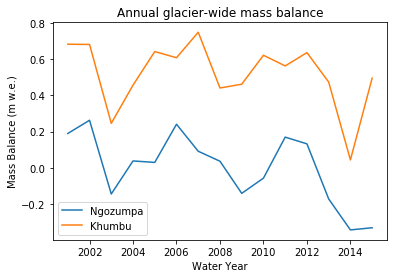

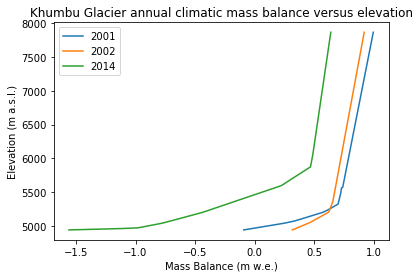

In [31]:
# Plot annual glacier-wide mass balance
plt.figure(1)
plt.plot(main_glac_massbal_annual.columns.values, main_glac_massbal_annual.iloc[0,:])
plt.plot(main_glac_massbal_annual.columns.values, main_glac_massbal_annual.iloc[1,:])
plt.legend(('Ngozumpa', 'Khumbu'))
plt.xlabel('Water Year')
plt.ylabel('Mass Balance (m w.e.)')
plt.title('Annual glacier-wide mass balance')

# Plot annual specific mass balance versus elevation
# print(glac_bin_massbal_annual.iloc[492:497,:])
# print(glac_bin_surftype_annual.iloc[492:497,:])
plt.figure(2)
plt.plot(glac_bin_massbal_annual.iloc[494:787, 0], glac_bin_massbal_annual.index.values[494:787])
plt.plot(glac_bin_massbal_annual.iloc[494:787, 1], glac_bin_massbal_annual.index.values[494:787])
plt.plot(glac_bin_massbal_annual.iloc[494:787, 13], glac_bin_massbal_annual.index.values[494:787])
# plt.plot(main_glac_massbal_annual.columns.values, main_glac_massbal_annual.iloc[1,:])
plt.legend(('2001', '2002', '2014'))
plt.xlabel('Mass Balance (m w.e.)')
plt.ylabel('Elevation (m a.s.l.)')
plt.title('Khumbu Glacier annual climatic mass balance versus elevation')

In [48]:
# MASS BALANCE CODE SEPARATED THAT NEEDS TO BE ADDED TO LINE ABOVE

#             # Update volume of next year
#             if (main_glac_area_annual.iloc[glac,year_position]) > 0:
#                 main_glac_volume_annual.iloc[glac,year_position + 1] = (main_glac_volume_annual.iloc[glac,year_position] +
#                     (main_glac_massbal_annual.iloc[glac,year_position]/1000 * main_glac_area_annual.iloc[glac,year_position]))
#                 # V(t+1)[km3] = V(t)[km3] + (B_annual[m] * (1 [km] / 1000 [m]) * Area[km2])

#             # Update area for the next year based on new volume
#             # Note: this will fail for the very last year, so need to adjust
#             #       this.  Also, need to change from constant area to
#             #       some sort of scaling mechanism
#             #   > Options:
#             #       - Volume-length scaling
#             #       - Volume-area scaling
#             #       - Volume-length-area scaling
#             #       - Normalized empirical adjustments (Huss and Hock, 2015)
#             main_glac_area_annual.iloc[glac, year_position + 1] = (
#                     main_glac_area_annual.iloc[glac, year_position])

#             print('main_glac_massbal_annual:\n'),
#             print(main_glac_massbal_annual.iloc[:, 0:5])
#             print('\nmain_glac_volume_annual:\n')
#             print(main_glac_volume_annual.iloc[:, 0:5])            

In [ ]:
# Aggregation to O1 and O2 RGI regions